## This script will adjust audio length to be equal to the length of the EEG trial. This is done by padding zeros to or discard extra audio sample from the end of the audio, so that the EEG data will never be modified.

### First, this script will adjust the audio length;

### Second, this script will extract EEG during task and discard non-task EEG, such as during pausing.

### The resulting audio/EEG can be used for spectrogram regression.

The recorded audio is missing some samples for each trial. A quick solutioin for alignment is to just pad zeros to the recordings.

In case first and last trial is not well-performed, those two trials will be discarded.

In [1]:
from speech_pinyin_Ruijin.config import *
import glob
from scipy.io import wavfile
import matplotlib.pylab as plt
import mne
import numpy as np
from utils.util_MNE import keep_annotation
import itertools

pre_all: Running from CMD.
common_dl.py: Using CUDA.


In [2]:
sid=1
folder=data_dir+str(sid)+'-*'
folder=os.path.normpath(glob.glob(folder)[0])
folder=folder.replace("\\", "/")
audio_folder=folder+'/raw/matlab/result/'
files=['name_202408280901','name_202408280930','name_202408280959']

In [3]:
session=3
file=audio_folder+files[session-1]+'/recording.wav'
sf_audio,audio=wavfile.read(file)

C:\Users\xiaowu\AppData\Local\Temp\ipykernel_37352\2686718653.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf_audio,audio=wavfile.read(file)


In [4]:
trial_begins=[]
beep=[1,0,1,0,1,0]
index=0
while index<len(audio)-10:
    if all(audio[index:index+6]==beep):
        trial_begins.append(index+6)
        index=index+5*48000 # jump before step-by-step search
    index=index+1
print(len(trial_begins))

144


In [5]:
# remove the beep
audio_clean=[]
lengths=[]
for i in range(len(trial_begins)):
    if i==len(trial_begins)-1:
        trial_start=trial_begins[i]
        tmp=audio[trial_start:]
    else:
        trial_start=trial_begins[i]
        trial_stop=trial_begins[i+1]-6
        tmp=audio[trial_start:trial_stop]
    length=len(tmp)
    lengths.append(length/48000)
    audio_clean.append(tmp)
print(len(audio_clean))

144


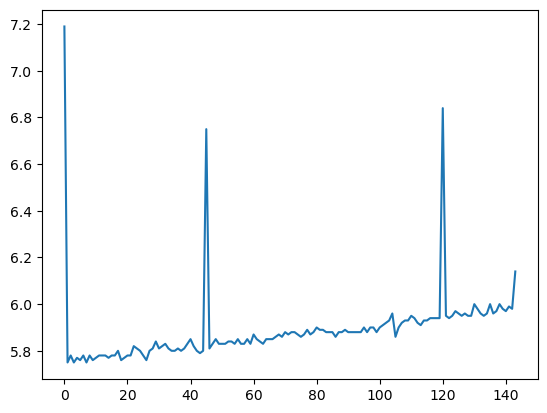

In [6]:
plt.plot(lengths)

144

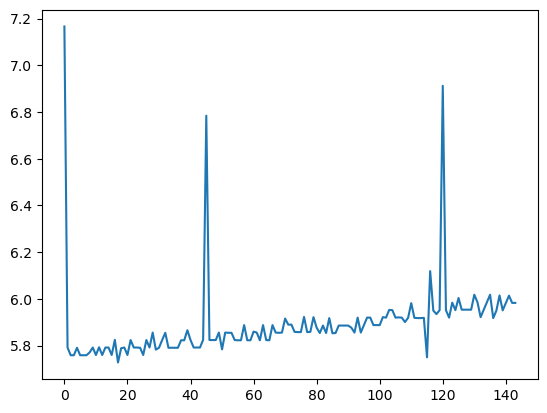

In [7]:
lengths2=np.load(folder+'/processed/session3'+'_trial_length_EEG.npy', allow_pickle=True) # 144
#lengths2=lengths2[1:-1]
plt.plot(lengths2)
len(lengths2)

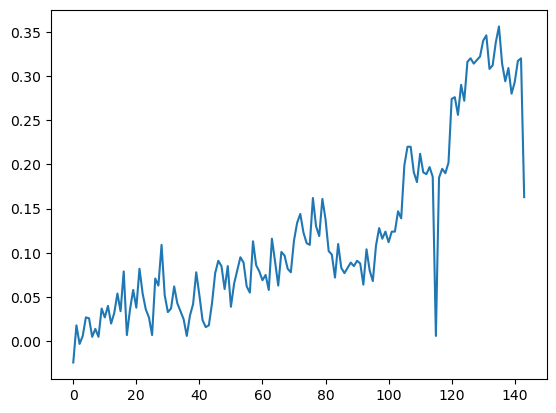

In [8]:
differences=[lengths2[i]-lengths[i] for i in range(len(lengths2))]
accum=np.cumsum(differences)#
plt.plot(accum)

In [9]:
len(trial_begins)

144

In [10]:
# padding the audio data
import math
padded_audio_list=[] 
lengths3=[]
lengths_sample=[]
#lengths3.append(0)
for i in range(len(trial_begins)):
    #if 0<i<len(trial_begins)-1: # discard the first and the last trials
    trial_start=trial_begins[i]
    if i==len(trial_begins)-1:
        trial_stop=len(audio)
    else:
        trial_stop=trial_begins[i+1]-6
    audio_length=trial_stop-trial_start
    eeg_length=int(lengths2[i]*48000)#trial_begins[i+1]-6
    
    padding_len=eeg_length-audio_length
    if padding_len>0:
        tmp=audio[trial_start:trial_stop]
        padding=[0,]*(padding_len)
        tmp=np.concatenate((tmp,np.asarray(padding)))
    elif padding_len<=0:
        tmp=audio[trial_start:(trial_start+eeg_length)]
    #extra=np.asarray([0]*10)
    #tmp=np.concatenate((tmp,extra))
    length_tmp=len(tmp)
    lengths_sample.append(length_tmp)
    lengths3.append(length_tmp/48000)
    padded_audio_list.append(tmp)
filename=folder+'/processed/session'+str(session)+'_audio_length_in_sample.npy'
np.save(filename, np.array(lengths_sample, dtype=object), allow_pickle=True)
#lengths3.append(0)
print(len(padded_audio_list))

144


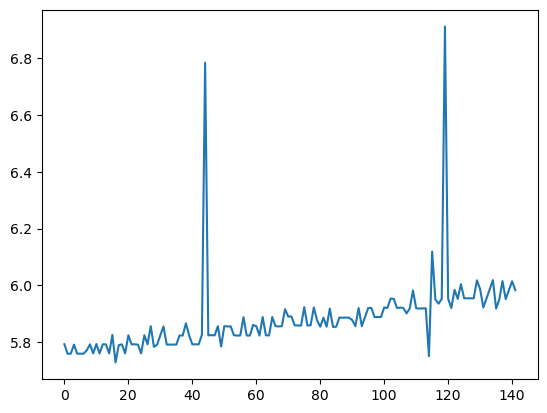

In [12]:
plt.plot(lengths3[1:-1])

142


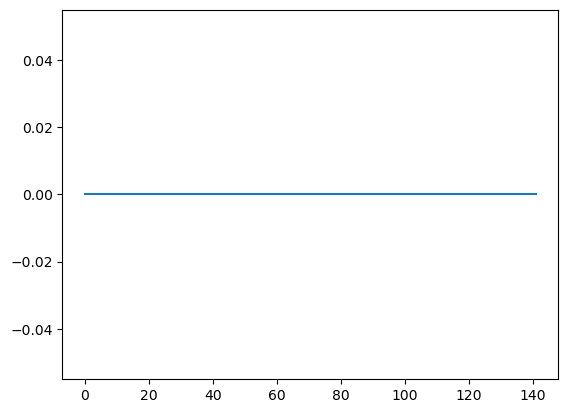

In [11]:
differences2=[lengths2[i]-lengths3[i] for i in range(1,len(lengths2)-1)]
accum=np.cumsum(differences2)#
print(len(differences2))
plt.plot(accum)

In [12]:
filename=folder+'/processed/session'+str(session)+'_listOfAudio_padded.npy'
np.save(filename, np.array(padded_audio_list, dtype=object), allow_pickle=True)

In [14]:
len(padded_audio_list)

144

Export the corrected audio file. This will be further denoised by the Audacity and used in the spectrogram regression task.

In [13]:
# stitch up the audio data
audio_padded=np.asarray(list(itertools.chain(*padded_audio_list)))
print(len(audio_padded)/48000) #ceil:842.3416666666667  #floor: 842.3388125  EEG: first trial + 835.21=842.376
filename=folder+'/processed/session'+str(session)+'_clean_audio_padded.wav'
wavfile.write(filename,48000,audio_padded)

848.323


### Extract EEG data during task and discard that during pause.

Loop through session value to extract the EEG data DURING TASK, which should be aligned well with audio data.

In [ ]:
#TODO: Not use session3_trigger_added-raw.fif anymore, should use session3_trials_list.npy in add_missing_trigger.ipynb instead.
#TODO: The late file is already segmented according to the task. Therefore, a whole EEG data can be obtained by concatenate that file.

In [17]:
session=3
#filename=folder+'/processed/session'+str(session)+'.fif'
filename=folder+'/processed/session3_trigger_added-raw.fif'
raw=mne.io.read_raw_fif(filename)

In [ ]:
%matplotlib qt
raw.plot()

In [18]:
all_events, all_event_id = mne.events_from_annotations(raw)
annotations=raw.annotations

In [19]:
audio_range=[a['onset'] for a in annotations if a['description']=='10']
print(len(audio_range))
pauses=[a['onset'] for a in annotations if a['description']=='2']
print(len(pauses))
trial_begins=[a['onset'] for a in annotations if a['description']=='5']
print(len(trial_begins))

2
6
144


In [ ]:
# discard pause data
if session==3:
    raw_task=mne.concatenate_raws([raw.copy().crop(audio_range[0]-raw.first_time,pauses[0]-raw.first_time),
                    raw.copy().crop(pauses[1]-raw.first_time,pauses[2]-raw.first_time),
                    raw.copy().crop(pauses[3]-raw.first_time,pauses[4]-raw.first_time),
                    raw.copy().crop(pauses[5]-raw.first_time,audio_range[1]-raw.first_time)]
                    )  # 848.4 s
    # raw_task=mne.concatenate_raws([raw.copy().crop(trial_begins[1]-raw.first_time,pauses[0]-raw.first_time),
    #                 raw.copy().crop(pauses[1]-raw.first_time,pauses[2]-raw.first_time),
    #                 raw.copy().crop(pauses[3]-raw.first_time,pauses[4]-raw.first_time),
    #                 raw.copy().crop(pauses[5]-raw.first_time,trial_begins[-1]-raw.first_time)]
    #                 )
    
elif session==2:
    raw_task=mne.concatenate_raws([raw.copy().crop(audio_range[0]-raw.first_time,pauses[0]-raw.first_time),
                    raw.copy().crop(pauses[1]-raw.first_time,audio_range[1]-raw.first_time)]
                    )  # 848.7 s
elif session==1:
    raw_task=mne.concatenate_raws([raw.copy().crop(audio_range[0]-raw.first_time,pauses[0]-raw.first_time),
                                   raw.copy().crop(pauses[1]-raw.first_time,pauses[2]-raw.first_time),
                                   raw.copy().crop(pauses[3]-raw.first_time,audio_range[1]-raw.first_time)]
                    ) # 848.2 s

In [ ]:
print(raw_task.get_data().shape[1]/1000) # discard last trial

In [ ]:
filename=folder+'/processed/session'+str(session)+'_task_data_no_first_last_trial.fif'
raw_task.save(filename,overwrite=True)